In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataprep.eda import *
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [314]:
# helper functions

def get_pod(x):
    if (x.hour > 4) and (x.hour <= 8):
        return 'Early Morning'
    elif (x.hour > 8) and (x.hour <= 12 ):
        return 'Morning'
    elif (x.hour > 12) and (x.hour <= 16):
        return'Noon'
    elif (x.hour > 16) and (x.hour <= 20) :
        return 'Eve'
    elif (x.hour > 20) and (x.hour <= 24):
        return'Night'
    elif (x.hour <= 4):
        return'Late Night'

def create_dummies(data,column,prefix):
    dummies = pd.get_dummies(data[column.name],prefix = prefix)
    data = pd.concat([data,dummies],axis=1)
    data = data.drop(columns=[column.name])
    return data

def get_frequency(data,column,new_var):
    freq = column.value_counts()
    freq = pd.DataFrame(freq)
    freq["name"] = freq.index
    freq.rename(columns = {column.name:new_var, 'name':column.name}, inplace = True)
    data = data.merge(freq, on = column.name)
    data = data.drop(columns=[column.name])
    return data

def resamplingDataPrep(X_train, y_train, target_var): 
    # concatenate our training data back together
    resampling = X_train.copy()
    resampling[target_var] = y_train.values
    # separate minority and majority classes
    majority_class = resampling[resampling[target_var]==0]
    minority_class = resampling[resampling[target_var]==1]
    # Get a class count to understand the class imbalance.
    print('majority_class: '+ str(len(majority_class)))
    print('minority_class: '+ str(len(minority_class)))
    return majority_class, minority_class

def upsample_SMOTE(X_train, y_train, target_var, ratio):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=42, sampling_strategy=ratio)
    # sm = SMOTEENN(random_state=42,sampling_strategy=0.3)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    resampling = X_train_sm.copy()
    resampling[target_var] = y_train_sm.values
    majority_class = resampling[resampling[target_var]==0]
    minority_class = resampling[resampling[target_var]==1]
    print('majority_class: '+ str(len(majority_class)))
    print('minority_class: '+ str(len(minority_class)))

    return X_train_sm, y_train_sm


def prepare_data(data):
    X = data.drop(columns=['isFraud'])
    y = data['isFraud']
    X_train, X_rest, y_train, y_rest  = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.75, random_state=42, stratify=y_rest)

    return X_train,X_test,X_val,y_train,y_test,y_val
    

def get_month(x):
    return x.month
    

# Loading the Data

In [378]:
desc = pd.read_excel('data-dictionary.xlsx', index_col=0)
data_features = pd.read_csv('transactions_obf.csv')
data_labels = pd.read_csv('labels_obf.csv')
fraud_transactions = data_labels['eventId'].tolist()

In [316]:
data_features

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500
...,...,...,...,...,...,...,...,...,...,...
118616,2018-01-30T23:52:16Z,103590747A1,d3c036ac,0b1dae,6300,826,NN1,81,50.91,7500
118617,2018-01-30T23:57:16Z,18903650A1,e0ad403a,e5d3c5,5812,826,TW9,5,71.00,10500
118618,2018-01-30T23:59:03Z,103582443A1,d3c036ac,0b1dae,6300,826,NN1,81,17.00,8500
118619,2018-01-31T00:04:44Z,14841868A1,ec212849,1ab20c,4812,826,SL1,1,11.00,7500


In [317]:
data_features['merchantCountry'].value_counts()

826    95616
442    14929
840     2873
372     1414
250      483
       ...  
703        1
48         1
566        1
410        1
32         1
Name: merchantCountry, Length: 82, dtype: int64

In [318]:
pd.merge(data_features,data_labels,on='eventId')['merchantId'].value_counts()

4fd0ff    49
2be1cd    48
707b6c    19
6a5933    17
e57467    14
          ..
2c3fc4     1
cb180a     1
45d79b     1
da5585     1
1a0510     1
Name: merchantId, Length: 438, dtype: int64

# Creating Target Variable

In [319]:
data_features.loc[data_features['eventId'].isin(fraud_transactions) , 'isFraud'] = 1
data_features.loc[data_features['eventId'].isin(fraud_transactions) == False , 'isFraud'] = 0

In [320]:
data_features

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,isFraud
0,2017-01-01T00:00:00Z,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,0.0
1,2017-01-01T00:49:03Z,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,0.0
2,2017-01-01T00:43:17Z,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,0.0
3,2017-01-01T00:15:07Z,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,0.0
4,2017-01-01T00:37:09Z,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,0.0
...,...,...,...,...,...,...,...,...,...,...,...
118616,2018-01-30T23:52:16Z,103590747A1,d3c036ac,0b1dae,6300,826,NN1,81,50.91,7500,0.0
118617,2018-01-30T23:57:16Z,18903650A1,e0ad403a,e5d3c5,5812,826,TW9,5,71.00,10500,0.0
118618,2018-01-30T23:59:03Z,103582443A1,d3c036ac,0b1dae,6300,826,NN1,81,17.00,8500,0.0
118619,2018-01-31T00:04:44Z,14841868A1,ec212849,1ab20c,4812,826,SL1,1,11.00,7500,0.0


In [321]:
counts = data_features['isFraud'].value_counts()
print(f'Out of the total {len(data_features)} transactions, {dict(counts).get(0)} are genuine and {dict(counts).get(1)} are fraud.')


Out of the total 118621 transactions, 117746 are genuine and 875 are fraud.


# Dataset Visualisation

# transaction time

In [322]:
# transaction time has a very high cardinality with 99.6% unique values. It should not be used to train the model as it does not provide much information ot the model. Instead I have extracted the hour from the time and created a new feature which signifies the part of the day when the transaction was made. This can be a great feature as the model can spot patterns to identify suspicious behaviour in unusual time of the day. 

In [323]:
data_features['transactionTime'] = pd.to_datetime(data_features['transactionTime'])

In [324]:
data_features['transactionTime'][11200].month

2

In [325]:
def get_pod(x):
    if (x.hour > 4) and (x.hour <= 8):
        return 'Early Morning'
    elif (x.hour > 8) and (x.hour <= 12 ):
        return 'Morning'
    elif (x.hour > 12) and (x.hour <= 16):
        return'Noon'
    elif (x.hour > 16) and (x.hour <= 20) :
        return 'Eve'
    elif (x.hour > 20) and (x.hour <= 24):
        return'Night'
    elif (x.hour <= 4):
        return'Late Night'

In [326]:
data_features['transactionTime'] = pd.to_datetime(data_features['transactionTime'])
data_features['transactionMonth'] = data_features['transactionTime'].apply(get_month)
data_features['transactionTime'] = data_features['transactionTime'].apply(get_pod)

# pod_dummies = pd.get_dummies(data_features['transactionTime'],prefix = 'time')
# data_features = pd.concat([data_features,pod_dummies],axis=1)
# data_features = data_features.drop(columns=['transactionTime'])
data_features = create_dummies(data_features,data_features['transactionTime'],'time')



In [327]:
data_features

,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,isFraud,transactionMonth,time_Early Morning,time_Eve,time_Late Night,time_Morning,time_Night,time_Noon
0,18688431A1,94f9b4e7,b76d06,5968,826,CR0,1,10.72,7500,0.0,1,0,0,1,0,0,0
1,2164986A1,648e19cf,718cc6,5499,826,DE14,81,21.19,4500,0.0,1,0,0,1,0,0,0
2,31294145A1,c0ffab1b,94cafc,5735,442,NaN,81,5.04,9500,0.0,1,0,0,1,0,0,0
3,11162049A1,038099dd,7d5803,5499,826,NR1,81,21.00,7500,0.0,1,0,0,1,0,0,0
4,17067235A1,3130363b,12ca76,5411,826,M50,81,47.00,10500,0.0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118616,103590747A1,d3c036ac,0b1dae,6300,826,NN1,81,50.91,7500,0.0,1,0,0,0,0,1,0
118617,18903650A1,e0ad403a,e5d3c5,5812,826,TW9,5,71.00,10500,0.0,1,0,0,0,0,1,0
118618,103582443A1,d3c036ac,0b1dae,6300,826,NN1,81,17.00,8500,0.0,1,0,0,0,0,1,0
118619,14841868A1,ec212849,1ab20c,4812,826,SL1,1,11.00,7500,0.0,1,0,0,1,0,0,0


# eventID

In [328]:
# similar to transaction time 'eventId' has a very high cardinality as well with 100% unique values and it should not be used to train the model. Hence we drop this column from our feature set.
data_features = data_features.drop(columns=['eventId'])

# Account Number

In [329]:
# Account Number has just 766 unique values which is 0.6% of the total values. Account number as it is can't be a great predictor as it is just an id and does not provide any information. But instead 
# the frequency of the account numbers can be calculated and used as a feature. The number of transactions by the same account is definitely a great predictor for fraud detection systems.
# High number of transactions from the same account can signal towards a probable fraud.

In [330]:
# acc_freq = data_features.accountNumber.value_counts()
# acc_freq = pd.DataFrame(acc_freq)
# acc_freq["name"] = acc_freq.index
# acc_freq.rename(columns = {'accountNumber':'acc_freq', 'name':'accountNumber'}, inplace = True)
# data_features = data_features.merge(acc_freq, on = 'accountNumber')
# data_features = data_features.drop(columns=['accountNumber'])
# mm = StandardScaler()
# data_features['acc_freq'] = mm.fit_transform(data_features[['acc_freq']])
mm = StandardScaler()
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
data_features = get_frequency(data_features,data_features.accountNumber,'acc_freq')
data_features['acc_freq'] = rs.fit_transform(data_features['acc_freq'].values.reshape(-1,1))


# Merchant Id

In [331]:
# Merchant Id is a unique id of the merchant and has 33327 unique values. It should not be used as it is while training the model because of its very high cardinality. Frequency of the merchant id could be used but there is a high chance that it gets correlated with 'mcc' as similar merchant ids will always have similar mcc.
#  Hence we drop this column from our feature set.
data_features = data_features.drop(columns=['merchantId'])

# MCC


In [332]:
# MCC represents the merchant category code of the merchant. It specifies the type of goods or services the merchant provides. It has a high cardinality as well and hence we use the frequency of MCC instead of the MCC codes. 
# The frequency will represent the number of times a specific type of service or goods category appeared. 

In [333]:
# mcc_freq = data_features.mcc.value_counts()
# mcc_freq = pd.DataFrame(mcc_freq)
# mcc_freq["mcc_code"] = mcc_freq.index
# mcc_freq.rename(columns = {'mcc':'mcc_freq', 'mcc_code':'mcc'}, inplace = True)
# data_features = data_features.merge(mcc_freq, on = 'mcc')
# data_features = data_features.drop(columns=['mcc'])
# # data_features['mcc_freq'] = np.log(data_features['mcc_freq']+0.01)


In [334]:
data_features = get_frequency(data_features,data_features['mcc'],'mcc_freq')
# data_features['mcc_freq'] = mm.fit_transform(data_features[['mcc_freq']])
data_features['mcc_freq'] = rs.fit_transform(data_features['mcc_freq'].values.reshape(-1,1))


# Merchant Country

In [335]:
# It is the country of the merchant who charged for the transaction. It contains 82 different countries. Using label encoder 

In [336]:
merchant_country_freq = pd.DataFrame(data_features.merchantCountry.value_counts())
merchant_country_freq["mc"] = merchant_country_freq.index
country_list = merchant_country_freq.loc[merchant_country_freq.merchantCountry>100,"mc"] # extracting countires whose transaction frequency is more than 100
data_features.loc[data_features["merchantCountry"].isin(country_list)==False,"merchantCountry"]="low_freq_countires" # marking rest countries as "low_freq_countries"

# mc_dummies = pd.get_dummies(data_features['merchantCountry'],prefix = 'mc')
# data_features = pd.concat([data_features,mc_dummies],axis=1)
# data_features = data_features.drop(columns=['merchantCountry'])
data_features = create_dummies(data_features,data_features['merchantCountry'],'mc')


In [337]:
data_features

,merchantZip,posEntryMode,transactionAmount,availableCash,isFraud,transactionMonth,time_Early Morning,time_Eve,time_Late Night,time_Morning,...,mc_292,mc_372,mc_380,mc_442,mc_528,mc_724,mc_756,mc_826,mc_840,mc_low_freq_countires
0,CR0,1,10.72,7500,0.0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,UB11,1,8.45,7500,0.0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,CR0,1,11.98,8500,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,TS17,1,25.22,7500,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,UB11,1,8.38,7500,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118616,NaN,1,122.91,500,0.0,6,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
118617,NaN,1,309.67,1500,0.0,7,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
118618,NaN,90,38.26,1500,0.0,12,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
118619,74133,81,1230.04,8500,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Merchant Zip

In [338]:
# It is the zip code of the postal address of the merchant. This column cointains 23005 missing values and the best method is to drop the column.
print('The number of na values for the feature "merchantZip" is', data_features.apply(lambda x : x.isnull().sum()).to_dict().get('merchantZip'))
data_features = data_features.drop(columns=['merchantZip'])

The number of na values for the feature "merchantZip" is 23005


# POS Entry Mode

In [339]:
# It represents the point of sale entry mode and there are just 10 distinct values hence we should use a one hot encoder. This can be done using the 
# get_dummies function from pandas.
data_features['posEntryMode'].value_counts()
# pos_dummies = pd.get_dummies(data_features['posEntryMode'],prefix='pos_mode')
# data_features = pd.concat([data_features,pos_dummies],axis=1)
# data_features = data_features.drop(columns=['posEntryMode'])
data_features = create_dummies(data_features,data_features['posEntryMode'],'pos_mode')

# Transaction Amount

In [379]:
# This column contains a certain number of negative values which are not veyr high in magnitude. The minimum tranasction amount is "-0.15". 
# We can either reomove these 183 values or make them zero. It wont make a huge difference if I perform any of these two methods
# but leaving the negative values as it is can degrade the performance of our classifier. I chose to remove the observations as -ve transaction values don't make sense
# and making them zero without any strong reason would not make any sense. As far as the skewness of this feature is concerned, I do not plan to use a parametric model 
# hence transforming the values according to a specific distribution won't make sense. 
neg_indexes = data_features[ data_features['transactionAmount'] < 0 ].index
data_features.drop(neg_indexes , inplace=True)
# data_features['transactionAmount'] = np.log(data_features['transactionAmount'] + 0.01)
# data_features['transactionAmount'] = mm.fit_transform(data_features[['transactionAmount']])
data_features['transactionAmount_1'] = rs.fit_transform(data_features['transactionAmount'].values.reshape(-1,1))

In [381]:
data_features.describe()

,mcc,merchantCountry,posEntryMode,transactionAmount,availableCash,transactionAmount_1
count,118438.000000,118438.000000,118438.000000,118438.000000,118438.000000,118438.000000
mean,5834.560251,759.118594,28.488365,53.757776,6625.103430,0.816706
std,976.263637,153.998420,35.621467,183.795005,3411.326979,4.490472
min,742.000000,31.000000,0.000000,0.000000,500.000000,-0.496702
25%,5411.000000,826.000000,5.000000,8.070000,4500.000000,-0.299536
50%,5691.000000,826.000000,5.000000,20.330000,7500.000000,0.000000
75%,5967.000000,826.000000,81.000000,49.000000,8500.000000,0.700464
max,9405.000000,840.000000,91.000000,13348.000000,18500.000000,325.621060


# Available Cash

In [374]:
# This column seems to be perfectly fine and can be used in our prediction models as it is. 
# data_features['availableCash'] = mm.fit_transform(data_features[['availableCash']])
# data_features['availableCash'] = rs.fit_transform(data_features['availableCash'].values.reshape(-1,1))
data_features['availableCash_log'] = np.log(data_features['availableCash'] + 0.01)
data_features = data_features.drop(columns=['availableCash'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Data set balance

With only 0.74% transactions that are fraudulent, a classifier that predicts every transaction to be not fraudulent will achieve accuracy score of 99.26%. However, such a classifier is valueless. Therefore, in the cases when classes are imbalanced, metrics other than accuracy should be considered. These metrics include precision, recall and a combination of these two metrics (F2).



In [343]:
# the target variable "isFraud" is highly imbalanced. In such case the classifier will favour the majority classs start generating false predictions.
# Hence we upsample the minority class using synthetic monetory upsampling technique. 

In [344]:
# The penalty for mislabeling a fraud transaction as legitimate is having a user’s money stolen, which the credit card company
# typically reimburses. On the other hand, the penalty for mislabeling a legitimate transaction as fraud is having the user frozen
# out of their finances and unable to make payments. Balancing the data keeping in mind that we need to catch most of the fraudulent
# transactions and have the least number of false positives. I will be using 

In [345]:
# After reviewing many techniques and the problem statement, I reached to a conclusion that false positives should be minimum and recall at the same time should be 
# good as well. Hence I did not oversample with 1:1 ratio. More the synthetic samples the model sees, more the recall but also the chance of getting 
# false positives increases a lot. 

In [346]:
# X = data_features.drop(columns=['isFraud'])
# y = data_features['isFraud']

In [347]:
# X_train, X_rest, y_train, y_rest  = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.75, random_state=42, stratify=y_rest)

In [348]:
X_train,X_test,X_val,y_train,y_test,y_val = prepare_data(data_features)

In [349]:
maj_class, min_class = resamplingDataPrep(X_train,y_train,'isFraud')

X_train_sm, y_train_sm = upsample_SMOTE(X_train,y_train,'is_Fraud',1)

majority_class: 82296
minority_class: 610
majority_class: 82296
minority_class: 82296


# Experimenting with different models

In [350]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import IsolationForest

# #store Logictic Regression
# logisticRegr = RandomForestClassifier()
# #fit model to logistic regression
# logisticRegr.fit(X_train_sm, y_train_sm)
# #predict using model
# pred = logisticRegr.predict(X_test)
# #print classification report 
# print('Logistic Regression:')
# print(classification_report(y_test, pred))
# print(confusion_matrix(y_test,pred))

In [351]:

# from sklearn.metrics import PrecisionRecallDisplay

# display = PrecisionRecallDisplay.from_estimator(
#     logisticRegr, X_test, y_test, name="RandomForest"
# )
# _ = display.ax_.set_title("Precision-Recall curve")

In [352]:
# # Wow our scores are getting even high scores even when applying cross validation.
# from sklearn.model_selection import cross_val_score


# for key, classifier in classifiers.items():
#     classifier.fit(X_train, y_train)
#     training_score = cross_val_score(classifier, X_train, y_train, cv=5)
#     print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

In [353]:
# feature_imp = pd.DataFrame(sorted(zip(logisticRegr.feature_importances_,X.columns)), columns=['Value','Feature'])

# plt.figure(figsize=(20, 10))
# sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
# plt.title('Random Forest')
# plt.tight_layout()
# plt.show()
# plt.savefig('f-imp.png')

array([[<AxesSubplot:title={'center':'mcc'}>,
        <AxesSubplot:title={'center':'merchantCountry'}>],
       [<AxesSubplot:title={'center':'posEntryMode'}>,
        <AxesSubplot:title={'center':'transactionAmount'}>],
       [<AxesSubplot:title={'center':'availableCash'}>,
        <AxesSubplot:title={'center':'transactionAmount_1'}>]],
      dtype=object)

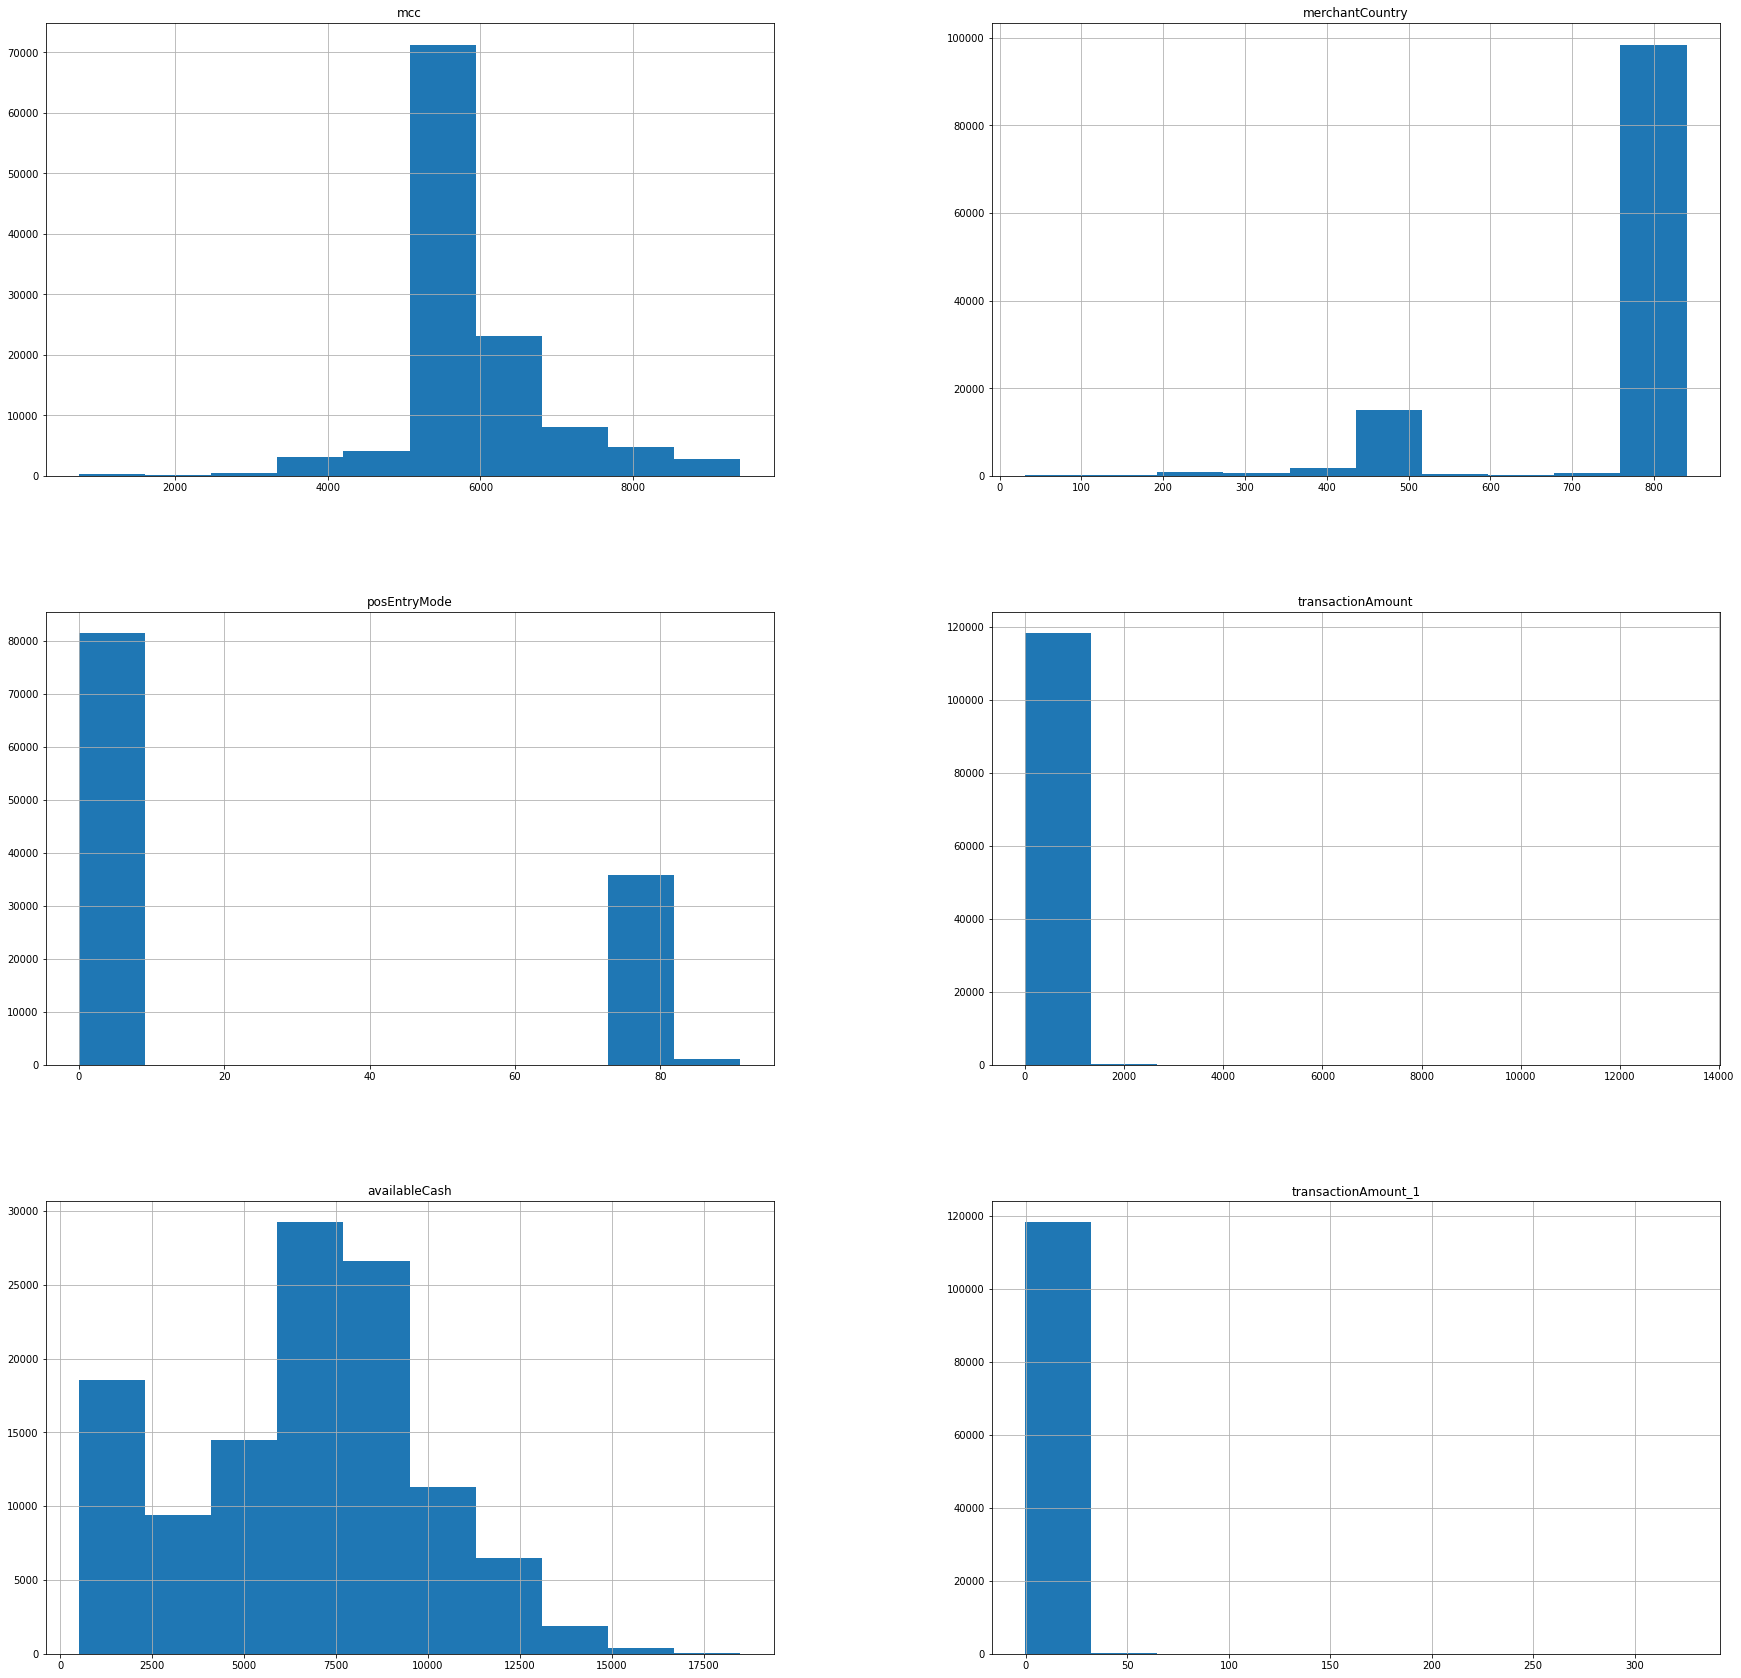

In [380]:
data_features.hist(figsize=(30,30))

In [354]:
from sklearn.metrics import f1_score, precision_score, recall_score
models = {'LogisticRegression': LogisticRegression(),
'DecisionTree':DecisionTreeClassifier(),
'RandomForest':RandomForestClassifier(),
'XGBoost':XGBClassifier(),
'ADABoost': AdaBoostClassifier()
# 'IsolationForest':IsolationForest()
}

f1 = []
f1_b = []

for x,y in models.items():
    unb_model = y.fit(X_train,y_train)
    preds_wob = unb_model.predict(X_test)
    f1.append([x,precision_score(y_test,preds_wob),recall_score(y_test,preds_wob),f1_score(y_test,preds_wob)])

for u,v in models.items():
    b_model = v.fit(X_train_sm,y_train_sm)
    preds_b = b_model.predict(X_test)
    f1_b.append([u,precision_score(y_test,preds_b),recall_score(y_test,preds_b),f1_score(y_test,preds_b)])

print('Before Balancing')
f1 = pd.DataFrame(f1,columns=['models','precision_score','recall_score','f1_score'])
print(f1)
print('-'*70)
print('After Balancing')
f1_b = pd.DataFrame(f1_b,columns=['models','precision_score','recall_score','f1_score'])
print(f1_b)
    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444:

Before Balancing
               models  precision_score  recall_score  f1_score
0  LogisticRegression         0.000000      0.000000  0.000000
1        DecisionTree         0.495652      0.581633  0.535211
2        RandomForest         0.950000      0.484694  0.641892
3             XGBoost         0.859504      0.530612  0.656151
4            ADABoost         0.090909      0.005102  0.009662
----------------------------------------------------------------------
After Balancing
               models  precision_score  recall_score  f1_score
0  LogisticRegression         0.045333      0.693878  0.085106
1        DecisionTree         0.375000      0.612245  0.465116
2        RandomForest         0.760000      0.581633  0.658960
3             XGBoost         0.610577      0.647959  0.628713
4            ADABoost         0.042481      0.765306  0.080494


In [355]:
max_recall_unb = max(f1["recall_score"])

In [356]:
xgb = XGBClassifier()
xgb.fit(X_train_sm,y_train_sm)
xgb_pred = xgb.predict(X_test)
print(classification_report(y_test,xgb_pred))
print(confusion_matrix(y_test,xgb_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     26453
         1.0       0.61      0.65      0.63       196

    accuracy                           0.99     26649
   macro avg       0.80      0.82      0.81     26649
weighted avg       0.99      0.99      0.99     26649

[[26372    81]
 [   69   127]]


array([[<AxesSubplot:title={'center':'transactionAmount'}>,
        <AxesSubplot:title={'center':'availableCash'}>,
        <AxesSubplot:title={'center':'isFraud'}>,
        <AxesSubplot:title={'center':'transactionMonth'}>,
        <AxesSubplot:title={'center':'time_Early Morning'}>,
        <AxesSubplot:title={'center':'time_Eve'}>],
       [<AxesSubplot:title={'center':'time_Late Night'}>,
        <AxesSubplot:title={'center':'time_Morning'}>,
        <AxesSubplot:title={'center':'time_Night'}>,
        <AxesSubplot:title={'center':'time_Noon'}>,
        <AxesSubplot:title={'center':'acc_freq'}>,
        <AxesSubplot:title={'center':'mcc_freq'}>],
       [<AxesSubplot:title={'center':'mc_124'}>,
        <AxesSubplot:title={'center':'mc_196'}>,
        <AxesSubplot:title={'center':'mc_208'}>,
        <AxesSubplot:title={'center':'mc_250'}>,
        <AxesSubplot:title={'center':'mc_276'}>,
        <AxesSubplot:title={'center':'mc_292'}>],
       [<AxesSubplot:title={'center':'mc_372'}

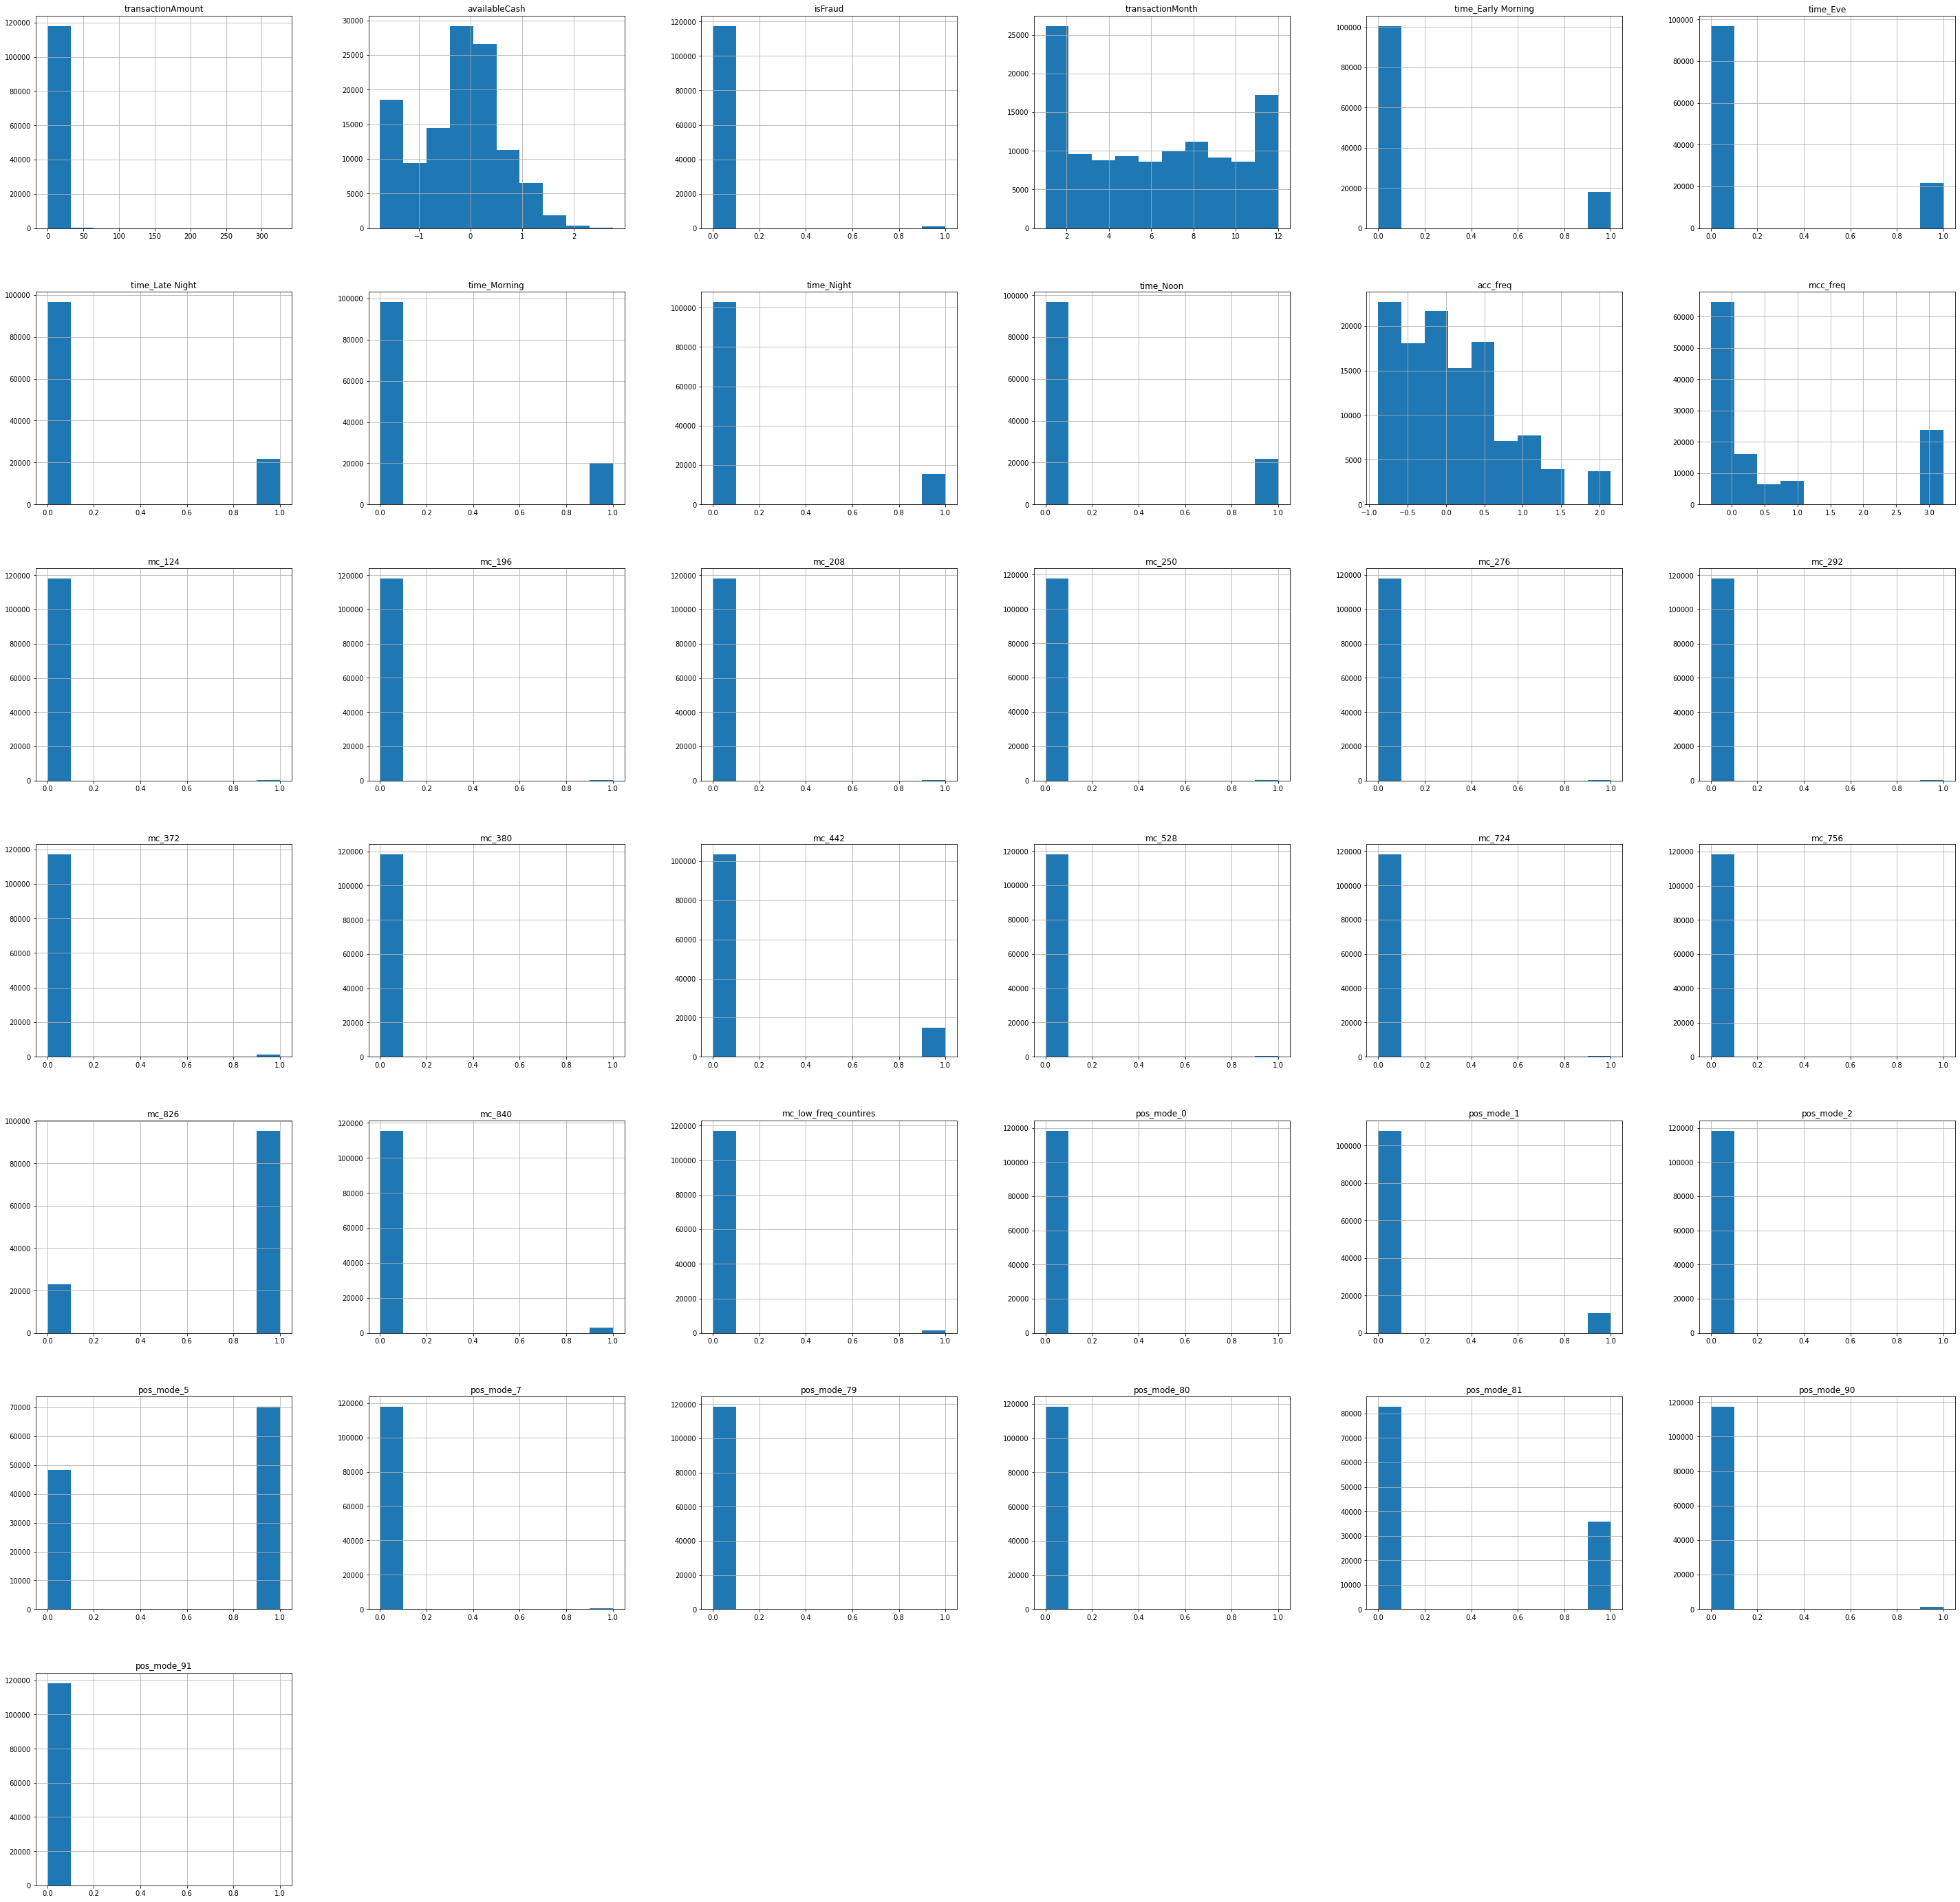

In [357]:
data_features.hist(figsize=(50,50))

In [360]:
lr = RandomForestClassifier()
lr.fit(X_train,y_train)
p = lr.predict(X_test)
print(classification_report(y_test,p))
print(confusion_matrix(y_test,p))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     26453
         1.0       0.95      0.48      0.64       196

    accuracy                           1.00     26649
   macro avg       0.97      0.74      0.82     26649
weighted avg       1.00      1.00      1.00     26649

[[26448     5]
 [  101    95]]


In [359]:
X_train

,transactionAmount,availableCash,transactionMonth,time_Early Morning,time_Eve,time_Late Night,time_Morning,time_Night,time_Noon,acc_freq,...,pos_mode_0,pos_mode_1,pos_mode_2,pos_mode_5,pos_mode_7,pos_mode_79,pos_mode_80,pos_mode_81,pos_mode_90,pos_mode_91
96314,0.456145,-1.75,1,0,0,0,0,0,1,-0.808314,...,0,0,0,1,0,0,0,0,0,0
16618,0.333985,0.25,2,1,0,0,0,0,0,0.568129,...,0,0,0,1,0,0,0,0,0,0
31079,-0.355729,0.00,12,0,0,0,1,0,0,0.863741,...,0,0,0,1,0,0,0,0,0,0
12577,-0.471537,0.00,9,0,0,0,0,0,1,0.073903,...,0,0,0,0,0,0,0,1,0,0
50443,-0.344979,1.50,11,0,1,0,0,0,0,1.900693,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5775,1.357195,-1.75,10,0,0,1,0,0,0,-0.771363,...,0,0,0,0,0,0,0,1,0,0
117872,1.050574,0.00,1,0,0,0,0,1,0,-0.182448,...,0,0,0,0,0,0,0,1,0,0
60741,5.123626,0.00,11,0,0,1,0,0,0,0.538106,...,0,1,0,0,0,0,0,0,0,0
42066,-0.387735,0.75,12,0,1,0,0,0,0,-0.637413,...,0,0,0,0,0,0,0,1,0,0


In [363]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit as sss
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
rfc_model=  imbpipeline(steps = [['smote', SMOTE(random_state=11)],['rfc', RandomForestClassifier()]])

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
rfc_param_grid={
    'rfc__n_estimators': [500, 800],
    'rfc__max_depth': [4, 5]}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

# Create a grid search object which will store the scores and hyperparameters of all candidate models 
rfc_param_grid = GridSearchCV(
    rfc_model, 
    rfc_param_grid,
    cv=stratified_kfold, verbose=10)

# Fit the models specified by the parameter grid 
tqdm(rfc_param_grid.fit(X_train, y_train))

# get the best hyperparameters from grid search object with its best_params_ attribute
print('Best parameters found:\n', rfc_param_grid.best_params_)

print(rfc_param_grid.best_score_)
rfc_grid_predict = rfc_param_grid.predict(X_val)
print(confusion_matrix(y_val,rfc_grid_predict))
print(classification_report(y_val,rfc_grid_predict))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START rfc__max_depth=4, rfc__n_estimators=500.....................
[CV 1/5; 1/4] END rfc__max_depth=4, rfc__n_estimators=500;, score=0.777 total time=  15.8s
[CV 2/5; 1/4] START rfc__max_depth=4, rfc__n_estimators=500.....................
[CV 2/5; 1/4] END rfc__max_depth=4, rfc__n_estimators=500;, score=0.791 total time=  16.4s
[CV 3/5; 1/4] START rfc__max_depth=4, rfc__n_estimators=500.....................
[CV 3/5; 1/4] END rfc__max_depth=4, rfc__n_estimators=500;, score=0.778 total time=  17.1s
[CV 4/5; 1/4] START rfc__max_depth=4, rfc__n_estimators=500.....................
[CV 4/5; 1/4] END rfc__max_depth=4, rfc__n_estimators=500;, score=0.771 total time=  15.2s
[CV 5/5; 1/4] START rfc__max_depth=4, rfc__n_estimators=500.....................
[CV 5/5; 1/4] END rfc__max_depth=4, rfc__n_estimators=500;, score=0.788 total time=  15.4s
[CV 1/5; 2/4] START rfc__max_depth=4, rfc__n_estimators=800.....................

0it [00:00, ?it/s]


Best parameters found:
 {'rfc__max_depth': 5, 'rfc__n_estimators': 500}
0.8092537075861207
[[7071 1746]
 [   3   63]]
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89      8817
         1.0       0.03      0.95      0.07        66

    accuracy                           0.80      8883
   macro avg       0.52      0.88      0.48      8883
weighted avg       0.99      0.80      0.88      8883



In [366]:
probs = rfc_param_grid.predict_proba(X_test)

In [367]:
probs

array([[0.90754681, 0.09245319],
       [0.95447921, 0.04552079],
       [0.97831715, 0.02168285],
       ...,
       [0.92400205, 0.07599795],
       [0.45435976, 0.54564024],
       [0.8667381 , 0.1332619 ]])